In [1]:
from shapely.geometry import MultiPolygon, Polygon

import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

from matplotlib import pyplot as plt

import requests
import arrow

In [2]:
def interpolate_perimeter(vertices, dnumber):
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def find_pairs(vertices_A, vertices_B):
    # Returns a list of quadruples: (AX, AY, BX, BY)
    
    number_of_vertices = max(len(vertices_A), len(vertices_B))
    
    vertices_A = interpolate_perimeter(vertices_A, number_of_vertices)
    vertices_B = interpolate_perimeter(vertices_B, number_of_vertices)
    
    # Find closest points to start with
    distance_to_zero = []
    for vertex_B in vertices_B:
        distance = np.sqrt((vertices_A[0][0] - vertex_B[0])**2 + 
                           (vertices_A[0][1] - vertex_B[1])**2)
        
        distance_to_zero.append(distance)
        
    minidx = np.argmin(distance_to_zero)
    
    return_list = []
    for i, vertex_A in enumerate(vertices_A):
        B_i = (i + minidx)%len(vertices_B)
        vertex_B = vertices_B[B_i]
        
        return_list.append((vertex_A[0], vertex_A[1], vertex_B[0], vertex_B[1]))
        
    return return_list

def collect_wx_data(centroid, fromdt, todt):
    km_per_miles = 1.60934
    
    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = centroid.x
    lat = centroid.y
    radius = 2*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

#     fromdt = ignite['datetime'].tz_localize('US/Pacific')
#     todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    return r.json()

def convolve_timeseries(times, values, hours=6):
    if np.unique(np.diff(times)).size > 1:
        print('Variable time interval is given! This is not yet implemented!')

    # Calculate the kernel size from the fixed time difference
    dt = times[1]-times[0]
    kernel_size = int(hours*3600/dt.total_seconds())
    if kernel_size%2 == 0:  # Make kernel size an odd number
        kernel_size += 1
        
    
    # Calculate the convolution:
    convolved_values = np.convolve(values, np.ones(kernel_size), mode='valid')/kernel_size
    clip_index = int((kernel_size-1)/2)
    time_clipped = times[clip_index:-clip_index]
    
    
    return time_clipped, convolved_values, clip_index

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1236: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  a = asanyarray(a)


13.281473944502702

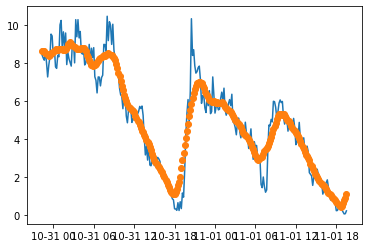

In [3]:
gdfMariaSim = pd.read_pickle('/home/tcaglar/farsite-devAPI/src/Maria2019_simulation.pkl')

df = pd.read_pickle('/home/tcaglar/data/test_table.pkl')
dfMaria = df[(df['description'] == 'Maria2019') & 
             (df['filetype'] == 'Ignition')]
for ix, row in dfMaria.iterrows():
    dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]
gdfMariaIgnition = gpd.GeoDataFrame(dfMaria, crs='EPSG:5070', geometry='geometry')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pan

In [4]:
gdfMariaIgnition.index

Index(['f23196b034474744bdca7df94b13e0f7', '9f82e870591748a9a8a01346d174f2a1',
       '1a6eb30ee33742e18fa6bb26678b5077', '911f9b001c054b74a6ba70958f5f3c93',
       '7957c2e604554199ba60c5b13aff2f40', '714f0cf8d475462a97c651642a3d2525',
       '628d7730c0f149f898695d37a1350882', '746e4f286cba4af4a89362b548f2c255',
       'ec72de65d1934e0ab74ff46ffba1ae1b', '15dc4b77768f4921be77c65ae9a6b9d4',
       'db87bccf2de3464ea09ffbe2c1fe1611', '548466fe1b424e62bc8d766234763fa2',
       '116dd0ef296445f39a3343b0daa1a084', '9623320b87894822a5ec1429be08f9bd',
       '04983f027cb4496da5a4d1177d28a801', '57a3d3ce84b2401ea89da919252ede28',
       'c9c4975019b947eab1e825ea811e9156', '49716755b8444847b9e030fa52481e05',
       'd6b0375e8f54460eac6a82223cc04337', '81011859d7ab456395abfab9112ee2a3'],
      dtype='object')

In [5]:
compareidx = '911f9b001c054b74a6ba70958f5f3c93'

vertices_observed = list(gdfMariaIgnition.loc[compareidx]['geometry'].exterior.coords)
centroid = gdfMariaIgnition.to_crs(epsg=4326).loc[compareidx, 'geometry'].centroid

fromdate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific') - datetime.timedelta(days=7)
todate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific')
wxdata = collect_wx_data(centroid, fromdate, todate)

https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.30974500294286&lon=-119.04971165334099&radius=3.21868&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-24T20:46:44-07:00&to=2019-10-31T21:06:44-07:00


In [6]:
for feature in wxdata['features']:
    name = feature['properties']['description']['name']
    wifireuid = feature['properties']['description']['wifire_uid']
    
    
    distance = feature['properties']['distanceFromLocation']
    coordinates = feature['geometry']['coordinates']
    
    times = pd.to_datetime(feature['properties']['timestamp'])
    
    units = feature['properties']['units']
    temperatures = feature['properties']['temperature']
    windspeeds = feature['properties']['wind_speed']
    winddirections = feature['properties']['wind_direction']
    
    print(f'name: {name}\ndist: {distance}')
    

name: SCE Hondo Barranca Rd
dist: {'value': 1.302025551560963, 'units': 'km'}


In [22]:
df = pd.DataFrame(index=times, data={'temperature': temperatures, 'windspeed': windspeeds, 'winddirection': winddirections})
df['U'] = df['windspeed']*np.cos(df['winddirection']/180*np.pi)
df['V'] = df['windspeed']*np.sin(df['winddirection']/180*np.pi)

ModuleNotFoundError: No module named 'sklearn'

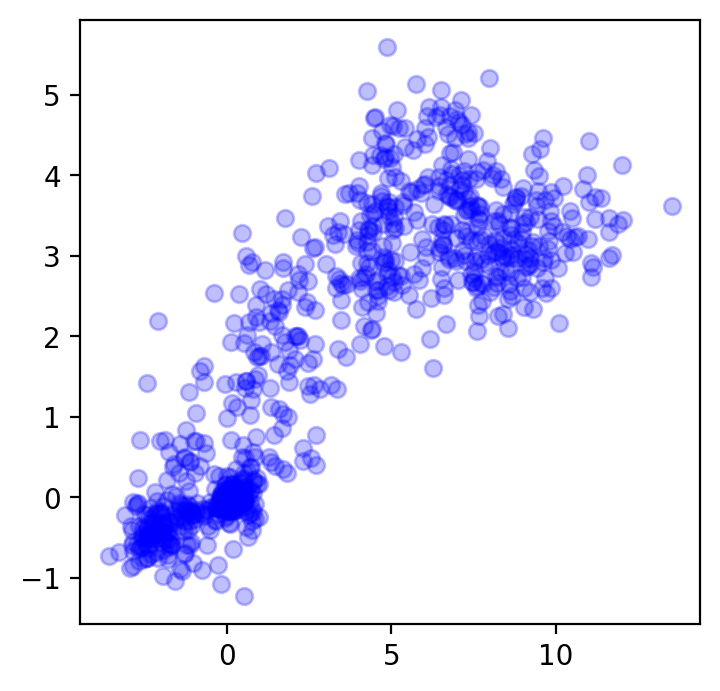

In [27]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.plot(df['U'], df['V'], 'o', color=(0,0,1, 0.25))

In [8]:
t, v, clip_idx = convolve_timeseries(times, windspeeds, hours=3)
plt.plot(t, windspeeds[clip_idx:-clip_idx], t, v, 'o')

# This will be the std.dev to select wind speeds
sigma_wx = np.sqrt(sum((v - windspeeds[clip_idx:-clip_idx])**2))

Variable time interval is given! This is not yet implemented!


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1236: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  a = asanyarray(a)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

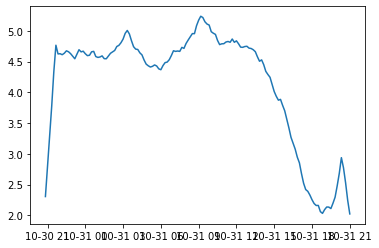

In [141]:
plt.plot(times, np.convolve(windspeeds, np.ones(10), mode='same')/sum(np.ones(10)))

In [94]:
windspeeds = gdfMariaSim['windspeed'].unique()
winddirections = gdfMariaSim['winddirection'].unique()

wsidx = 10
wdidx = 15

windspeed = windspeeds[wsidx]
winddirection = winddirections[wdidx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &
                                      (gdfMariaSim['winddirection'] == winddirection) &
                                      (gdfMariaSim['compareidx'] == compareidx)].iloc[0]['geometry'][0].exterior.coords)
vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

Calculating for ws=10.0, wd=90.0


In [95]:
vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

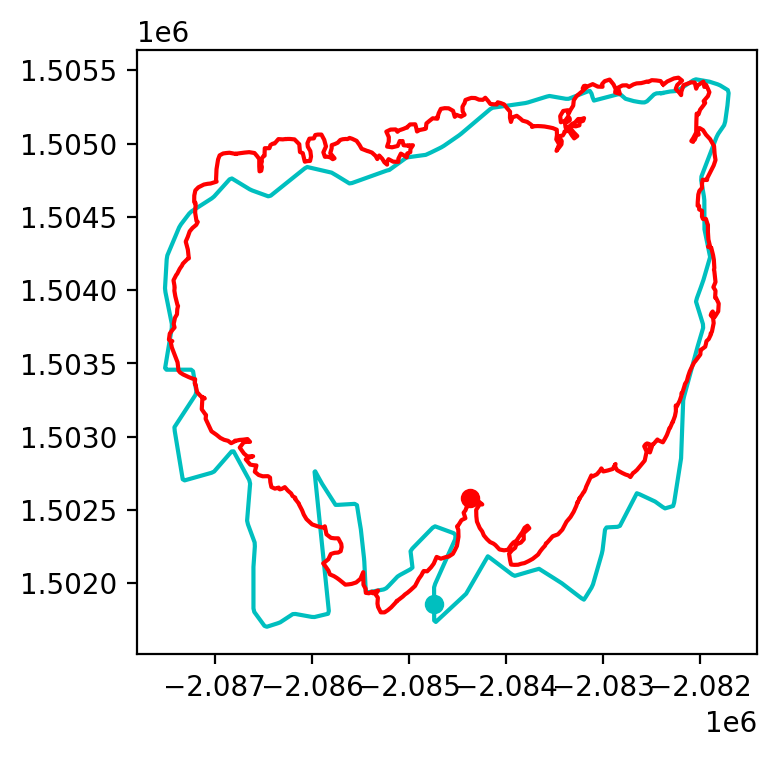

In [98]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[250,0], vertices_A[250,1], 'co')
ax.plot(vertices_B[250,0], vertices_B[250,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')